<h1 style="text-align:center;">Waste Classification - CNN - Keras & Tensorflow <h1>

## @Author: Group 1 - AWT306

Lu Quoc Khai Ho - A00096112

In [2]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import warnings
warnings.filterwarnings('ignore')
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image


# Model Hypertunning
!pip install -q keras_tuner
import keras_tuner as kt

import tensorflow as tf

# Fig GPU registration
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.config.list_physical_devices('GPU')
import keras
# from tensorflow.keras.applications import MobileNetV2


from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# tf.config.optimizer.set_jit(True) # optimize keras trainning process

2024-11-30 04:17:08.332961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 04:17:08.356802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 04:17:08.356837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 04:17:08.372751: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 04:17:09.135343: W tensorflow/compiler/tf

## Defining variables and reusable functions

In [3]:
# Define dataset folder
current_dir = os.path.dirname(os.path.abspath("__file__"))
data_dir =  current_dir + "/dataset"

# Set the testing directory path for model prediction
testing_dir = current_dir + "/test"

In [4]:
image_count = len(glob.glob(f'{data_dir}/*/*'))
print(f"Total images: {image_count}") # Count total images in dataset folder

Total images: 6060


### Visualize trainning result

In [39]:
def visualize_training_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"],label = "Train Loss")
    plt.plot(history.history["val_loss"],label = "Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Load data using a Keras utility

## Generate more dataset

This function is used to generate the images for the mall dataset which uses the same method with data augmentation and save data to each label folder

In [6]:
#generate images from existed dataset
def generate_dataset_image(dataset_path, number_images):
    print("Images are generating... ")
    datagen = ImageDataGenerator(
            rotation_range=40,
            height_shift_range=0.2,
            width_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
    )
    
    subfolders = glob.glob(f"{dataset_path}/*")
    
    labels = []
    
    for path in subfolders:
        label = path.split("/")[-1]
        files = glob.glob(f"{path}/*")
        j = 0
        for file in files:
            img = keras.utils.load_img(file)  # this is a PIL image
            x = keras.utils.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
            x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    
            # the .flow() command below generates batches of randomly transformed images
            # and saves the results to the `preview/` directory
            i = 0
            for batch in datagen.flow(x, batch_size=1,
                                      save_to_dir=f'{dataset_path}/{label}', save_prefix=f'generated.{j}.{label}', save_format='jpeg'):
                i += 1
                if i > (number_images - 1): # generate 1 image 3 times
                    break  # otherwise the generator would loop indefinitely
            j += 1
        
    print("Images generating is completed!")


In [7]:
# generate_dataset_image(data_dir, 9)

In [8]:
image_count = len(glob.glob(f'{data_dir}/*/*'))
print(f"total images: {image_count}")

total images: 6060


### Define some parameters for the loader:

In [9]:
batch_size = 32

img_height = 160
img_width = 160

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6060 files belonging to 4 classes.
Using 4242 files for training.


2024-11-30 04:17:16.611605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 04:17:16.613414: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 04:17:16.614793: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6060 files belonging to 4 classes.
Using 1818 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['glass', 'metal', 'paper', 'plastic']


## Visualize the data

Testing image that fit to the label in random 1 batch dataset

2024-11-30 04:17:21.397419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


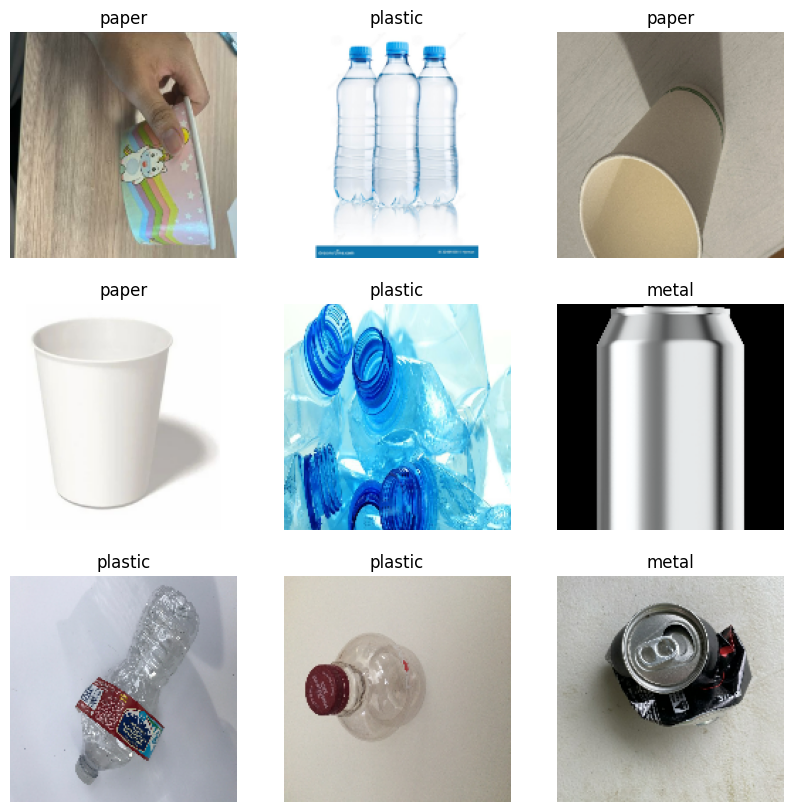

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


## Configure the dataset for performance

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Optimization for Training and Validation Datasets by caching and shuffling
# train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
# prefetching the training data to optimize pipeline
# train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Standardize the data

In [17]:
normalization_layer = layers.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.09077203 0.971777


# Overfitting Solutions

## 1. Data augmentation

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# # Apply data_augmentation to the training images.
# train_ds = train_ds.map(
#     lambda img, label: (data_augmentation(img), label),
#     num_parallel_calls=tf.data.AUTOTUNE,
# )
# # Prefetching samples in GPU memory helps maximize GPU utilization.
# train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

2024-11-30 04:17:38.057925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


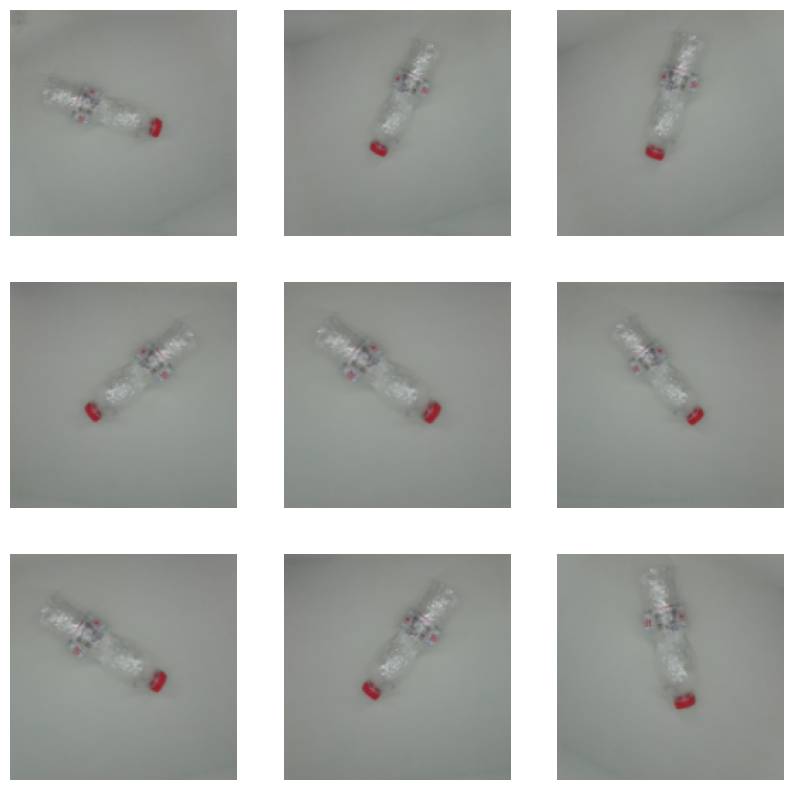

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
# dropout_rate = 0.3


# model = Sequential([
#     base_model,
#     data_augmentation,
#     layers.Rescaling(1./255),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(128, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(dropout_rate),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(dropout_rate),
    
#     layers.Dense(120, activation='relu'),
    
#     layers.Dropout(dropout_rate),
    
#     layers.Dense(num_classes, name="outputs")
# ])

In [22]:
dropout_rate = 0.5
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height,img_width,3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

model = Sequential([
#     data_augmentation,
#     layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(120, activation='relu',  kernel_initializer='he_normal'),
    layers.Dropout(dropout_rate),
    layers.Dense(num_classes, name="outputs",  activation='softmax')
])

In [23]:

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
#     optimizer='adam',
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       153,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 4)              │           484 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,412,188 (9.20 MB)

 Trainable params: 154,204 (602.36 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
epochs=100
early_stopping = keras.callbacks.EarlyStopping( monitor='val_loss',          
    mode='min',                   
    min_delta=0.01,              
    verbose=1,                    
    patience=10,                 
    restore_best_weights=True     
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/100


I0000 00:00:1732940264.040101   30278 service.cc:145] XLA service 0x2a02af90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732940264.040144   30278 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-11-30 04:17:44.130685: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 04:17:44.671436: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1732940267.204060   30624 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4373', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1732940267.210451   30626 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4373', 260 bytes spill stores, 260 bytes spill loads



 27/133 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3477 - loss: 1.7971

I0000 00:00:1732940270.652487   30278 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 46/133 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3936 - loss: 1.6133

I0000 00:00:1732940273.607103   30727 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4373', 260 bytes spill stores, 260 bytes spill loads



126/133 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4857 - loss: 1.3196

I0000 00:00:1732940284.293385   30894 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1177', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1732940284.816067   30891 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1170', 260 bytes spill stores, 260 bytes spill loads



133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 130ms/step - accuracy: 0.4911 - loss: 1.3035 - val_accuracy: 0.7283 - val_loss: 0.7022
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7082 - loss: 0.7519 - val_accuracy: 0.7767 - val_loss: 0.6110
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7714 - loss: 0.6269 - val_accuracy: 0.7866 - val_loss: 0.5784
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7821 - loss: 0.5737 - val_accuracy: 0.8020 - val_loss: 0.5272
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8143 - loss: 0.4869 - val_accuracy: 0.7954 - val_loss: 0.5441
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8072 - loss: 0.4753 - val_accuracy: 0.8031 - val_loss: 0.5025
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8391 - loss: 0.4283 - val_accuracy: 0.8311 - val_loss: 0.4747
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8632 - loss: 0.3730 - val_accuracy: 0.8

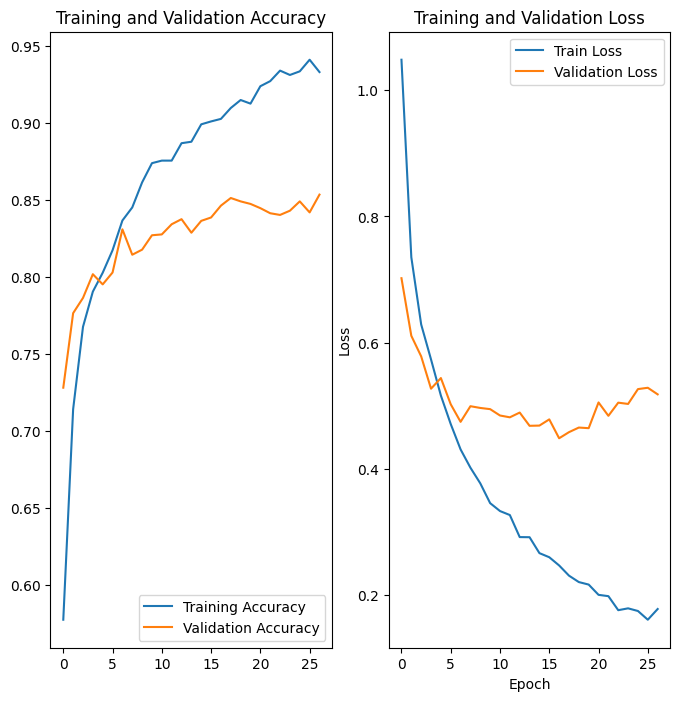

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"],label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save Keras model

In [27]:
model.save(f'{current_dir}/AWT306_Group1_CNN_Model.keras')
# model.export('model_export')

## MobileNetV2 Hypertuning

In [34]:
LEARNING_RATE = 1e-3
# dropout_rate = 0.5
LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
# LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
METRICS = ['accuracy']

def build_model(hp):
    
    # Define all hyperparms
    mobilenet = MobileNetV2(input_shape=(img_height,img_width,3), weights='imagenet', include_top=False)
    mobilenet.trainable = False
    n_layers = hp.Choice('n_layers', [1, 2, 3, 4])
    dropout_rate = hp.Choice('rate', [0.2, 0.3, 0.4, 0.7])
    n_units = hp.Choice('units', [64, 128, 256, 512])
    learning_rate = hp.Choice('lr', [LEARNING_RATE, LEARNING_RATE * 0.1, LEARNING_RATE*0.01])
    
    # Mode architecture
    model = Sequential([
        mobilenet,
        layers.GlobalAveragePooling2D(),
    ])
    
    # Add hidden/top layers 
    for _ in range(n_layers):
        model.add(layers.Dense(n_units, activation='relu', kernel_initializer='he_normal'))
    
    # Add Dropout Layer
    model.add(layers.Dropout(dropout_rate))
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
#     model.add(layers.Dense(num_classes))
    
    # Compile the model
    model.compile(
        loss=LOSS,
        optimizer = keras.optimizers.Adam(learning_rate),
        metrics = METRICS
    )
    
    # Return model
    return model

In [35]:
# Initialize Random Searcher
random_searcher = kt.RandomSearch(
    hypermodel=build_model, 
    objective='val_loss', 
    max_trials=20, 
    seed=42, 
    project_name="MobileNetSearch", 
    loss=LOSS)

# Start Searching
search = random_searcher.search(
    train_ds,
    validation_data=val_ds,
    epochs = epochs,
    batch_size = batch_size
)

Trial 20 Complete [00h 02m 39s]
val_loss: 0.5014258027076721

Best val_loss So Far: 0.4388747215270996
Total elapsed time: 00h 54m 16s


In [36]:
# Best Hyper params
best_hps = random_searcher.get_best_hyperparameters()[0]
print(f"Best Hyper Params founded: {best_hps.values}\n")

# Build the best model
mobile_net_model = build_model(best_hps)
mobile_net_model.summary()

# Compile the model
print("\nTraining Best Model Architecture : ")
early_stopping = keras.callbacks.EarlyStopping( monitor='val_loss',                            
    patience=5,                 
    restore_best_weights=True     
)

mobile_net_model_history = mobile_net_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[
        early_stopping,
        keras.callbacks.ModelCheckpoint('AWT306_Group1_CNN_Best_Model.keras', save_best_only=True)
    ]
)

mobile_net_model.export('model_export')

Best Hyper Params founded: {'n_layers': 1, 'rate': 0.7, 'units': 512, 'lr': 0.001}



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Training Best Model Architecture : 
Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.4872 - loss: 1.6448 - val_accuracy: 0.7349 - val_loss: 0.7024
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6782 - loss: 0.7960 - val_accuracy: 0.7657 - val_loss: 0.6183
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7279 - loss: 0.6762 - val_accuracy: 0.7690 - val_loss: 0.5998
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7549 - loss: 0.6390 - val_accuracy: 0.7932 - val_loss: 0.5487
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7685 - loss: 0.5730 - val_accuracy: 0.7877 - val_loss: 0.5415
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7957 - loss: 0.5336 - val_accuracy: 0.8146 - val_loss: 0.4977
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8007 - loss: 0.5201 - val_accuracy: 0.8042 - val_loss: 0.5185
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/ste

INFO:tensorflow:Assets written to: model_export/assets


Saved artifact at 'model_export'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_336')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139691285219984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691298755632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691285232832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691298762496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691285983328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691285231600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691281287120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691281293984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691281294160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691281285184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13969128129257

## Visualise the best model training 

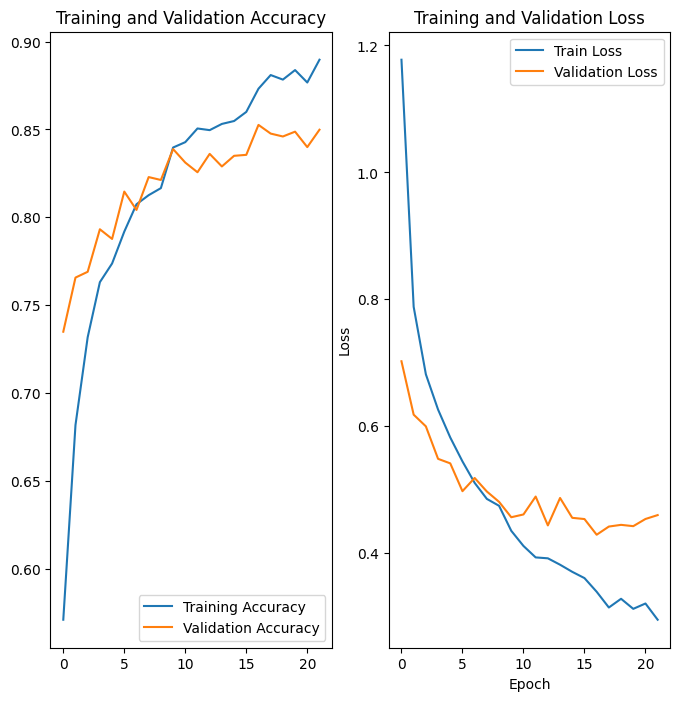

In [40]:
visualize_training_result(mobile_net_model_history)

## Load Keras Model

In [41]:
group1_cnn_model = tf.keras.models.load_model(f'{current_dir}/AWT306_Group1_CNN_Best_Model.keras', compile=False)

# Show the model architecture
group1_cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Predict on new data

In [42]:
import math
def resize_display_image(path, width):
    img = None
    if len(path):
        # Read the Image
        image = Image.open(path)
        ratio = (width/image.width)

        # Resize the image using resize() method
        image = image.resize((width, math.ceil(image.height * ratio)))
        
    return image

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
tf.Tensor([0.44087872 0.18235189 0.18127851 0.19549084], shape=(4,), dtype=float32)
['glass', 'metal', 'paper', 'plastic']
This image most likely belongs to glass with a 44.09 percent confidence.


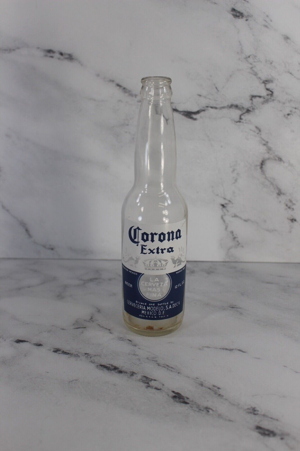

In [43]:
import random

animals = list(glob.glob(f'{testing_dir}/*'))

# Select a random item
#selected_item = random.choice(animals)
selected_item = testing_dir + '/corona-bottle.jpg'
img = tf.keras.utils.load_img(
    selected_item, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
# img_array = img_array/255.0

predictions = group1_cnn_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print(class_names)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# PIL.Image.open(str(selected_item))
resize_display_image(str(selected_item),300)

## Convert the Keras Sequential model to a TensorFlow Lite model

In [45]:
print(mobile_net_model)

<Sequential name=sequential_1, built=True>


In [46]:
print(mobile_net_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,231,758 (16.14 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 1,315,850 (5.02 MB)

None


In [ ]:
# Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(group1_cnn_model)
# # converter.target_spec.supported_ops = [
# #   tf.lite.OpsSet.TFLITE_BUILTINS, # enable LiteRT ops.
# #   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
# # ]
# tflite_model = converter.convert()

# # Save the model.
# with open('converted_model.tflite', 'wb') as f:
#   f.write(tflite_model)

In [47]:
converter = tf.lite.TFLiteConverter.from_saved_model('model_export')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable LiteRT ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
open(current_dir+"/raspberry_pi/awt306_model.tflite", "wb").write(tflite_model)

W0000 00:00:1732944719.648014   29478 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1732944719.648052   29478 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-11-30 05:31:59.648456: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model_export
2024-11-30 05:31:59.663535: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-11-30 05:31:59.663555: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: model_export
2024-11-30 05:31:59.834003: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-11-30 05:31:59.853272: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-11-30 05:32:00.513202: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: model_export
2024-11-30 05:32:00.686188: I tensorflow/cc/saved_model/loader.cc:317] SavedM

11497264

# Run the TensorFlow Lite model

In [48]:
TF_MODEL_FILE_PATH = current_dir+'/raspberry_pi/awt306_model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [49]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_336'], 'outputs': ['output_0']}}

In [50]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [65]:
predictions_lite = classify_lite(keras_tensor_336=img_array)['output_0']
score_lite = tf.nn.softmax(predictions_lite)
print(score_lite)

tf.Tensor([[0.44090086 0.1823544  0.18127759 0.1954672 ]], shape=(1, 4), dtype=float32)


In [66]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to glass with a 44.09 percent confidence.


In [59]:
print(np.max(np.abs(predictions - predictions_lite)))

0.00010538846
